# EEG Data
The data sets we will be working with are open source data collected at the École Polytechnique Fédéral de Lausanne for a BCI (Brain Computer Interface) project; the full data set and can downloaded [here](http://mmspg.epfl.ch/BCI_datasets). We have done some re-organization of the data to make it easier to load; if you would like to try to work with the whole data set, see the notebook [here](blah) for how we re-organized things.



# Imports etc (pre-Chris-stuff)

In [1]:
import os
import glob
import numpy as np
import scipy.io as si
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from scipy.stats import zscore
import datetime
%matplotlib inline

import mne

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.aspect'] = 'auto'

In [6]:
# From README
sfreq = 2048
offset_idx = 820 # = 400 ms * sfreq
electrode_names = ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 
                   'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 
                   'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 
                   'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 
                   'Cz', 'MA1', 'MA2']
reference_electrodes = [6,23] # note diff. in python indices
print([electrode_names[r] for r in reference_electrodes])
# images are arranged on screen like:
"""
     [1, 2,
      3, 4,
      5, 6]
""";

['T7', 'T8']


In [32]:
# Load data for testing / play
subject, session, run = 1, 1, 1
fdir = '../data/eeg/epfl_p300_speller/subject{}/session{}/'.format(subject, session)
files = sorted(glob.glob(os.path.join(fdir, '*mat')))
all_data = si.loadmat(files[run])

In [33]:
files

['../data/eeg/epfl_p300_speller/subject1/session1/eeg_200605191428_epochs.mat',
 '../data/eeg/epfl_p300_speller/subject1/session1/eeg_200605191430_epochs.mat',
 '../data/eeg/epfl_p300_speller/subject1/session1/eeg_200605191431_epochs.mat',
 '../data/eeg/epfl_p300_speller/subject1/session1/eeg_200605191433_epochs.mat',
 '../data/eeg/epfl_p300_speller/subject1/session1/eeg_200605191435_epochs.mat',
 '../data/eeg/epfl_p300_speller/subject1/session1/eeg_200605191437_epochs.mat']

In [8]:
# Deal with idiotic events array
def convert_time(tarray):
    te = tarray[:,-1:]
    tarray = np.hstack([tarray[:,:-1], np.floor(te), (te%1)*1000000])
    tarray = tarray.astype(np.int32)
    dt = [datetime.datetime(*t) for t in tarray]
    time = np.array([(x-dt[0]).total_seconds() for x in dt])
    return time

In [8]:
time = convert_time(all_data['events'])

In [9]:
all_data['events'][0], all_data['events'][-1]

(array([ 2006.   ,     5.   ,    19.   ,    14.   ,    29.   ,     9.808]),
 array([ 2006.   ,     5.   ,    19.   ,    14.   ,    30.   ,     2.293]))

In [12]:
time[-1] + 15.744 - 60

-5.2219990000000038

In [13]:
# Testing datetime
a = datetime.datetime(2016, 2, 27, 2, 14, 44, 123334) # last field is microseconds - max is 999999
b = datetime.datetime(2016, 2, 27, 2, 14, 45, 213456)

In [39]:
def load_p300_data(subject, session, run, ref_electrode_idx=(6,23), is_verbose=False):
    fdir = '../data/eeg/epfl_p300_speller/subject{}/session{}/'.format(subject, session)
    files = sorted(glob.glob(os.path.join(fdir, '*mat')))
    all_data = si.loadmat(files[run])
    # EEG data
    data = all_data['data']
    # Mastoid reference
    mastoids = data[-2:] # data[[-2, -1]] # what is this odd indexing? Does this copy the array or something?
    # Remove mastoids
    data = data[:-2]
    ref_electrodes = data[list(ref_electrode_idx)]
    if is_verbose:
        print("Reference electrode shape:",ref_electrodes.shape)
    #data -= mastoids.mean(0)
    data -= ref_electrodes.mean(0)
    # Smooth the data
    fmin, fmax = 1, 12 # From paper; done with butterworth filter in paper...
    data = mne.filter.filter_data(data, sfreq, fmin, fmax, verbose=False)
    # Image they were supposed to focus on
    true_target = all_data['target'].squeeze()
    # The number of times the subject reported the target flashed
    target_counts = all_data['targets_counted'].squeeze()
    # Image that was flashed for each event
    stimuli = all_data['stimuli'].squeeze()
    design = np.array([stimuli==x for x in np.unique(all_data['stimuli'])])
    # Time of each event in seconds
    event_times = convert_time(all_data['events'])
    
    return data, design, event_times, target_counts, true_target

In [21]:
# First event actually occurs at 400 ms into scan (times are clock times, thus do not reflect that)
np.ceil(sfreq*0.4)

820.0

In [22]:
# To avoid dealing with rounding errors, just use this instead
offset_idx

820

In [37]:
first_onset = 0.400 # 400 ms
offset_idx_ = int(np.ceil(sfreq*first_onset))
assert offset_idx==offset_idx, 'Offset indices are not equal!'

def extract_epochs(data, onset_times, tmin=-0.1, tmax=0.6, sfreq=2048, 
                   offset_idx=offset_idx, is_verbose=False):
    """Extract peri-stimulus epochs"""
    epochs = []    
    for time in onset_times:
        # Find event onset / offset index
        #time_scaled = time - t0 # first time is already zero
        
        onset_index = int(sfreq * time) + offset_idx
        if is_verbose:
            print('Onset index = %d'%onset_index)
        event_start_idx = onset_index + int(sfreq * tmin)
        event_end_idx = onset_index + int(sfreq * tmax)
        if is_verbose:
            print("Extracting indices from %d to %d"%(event_start_idx, event_end_idx))
        # Calculate window
        data_slice = data[:, event_start_idx:event_end_idx]
        data_slice = zscore(data_slice, axis=1)
        if is_verbose:
            print("Data slice is of shape {}".format(data_slice.shape))
        epochs.append(data_slice)
    # Concatenate together all epochs we have extracted
    epochs = np.array(epochs)
    times = np.linspace(tmin, tmax, num=epochs.shape[-1])

    # Baseline by pre-stimulus times
    baseline_type = 'zscore'  # 'zscore' , 'mean'
    epochs = mne.baseline.rescale(epochs, times, (None, 0), baseline_type, verbose=is_verbose)
    return epochs, times

In [40]:
subject = 8 # 1-2 (9 total, not downloaded...)
session = 2 # 1-4
run = 1
data, design, event_times, target_counts, target = load_p300_data(subject, session, run)
epochs = {}
for icond, cond in enumerate(design):
    epochs[icond+1], times = extract_epochs(data, event_times[cond][:3])

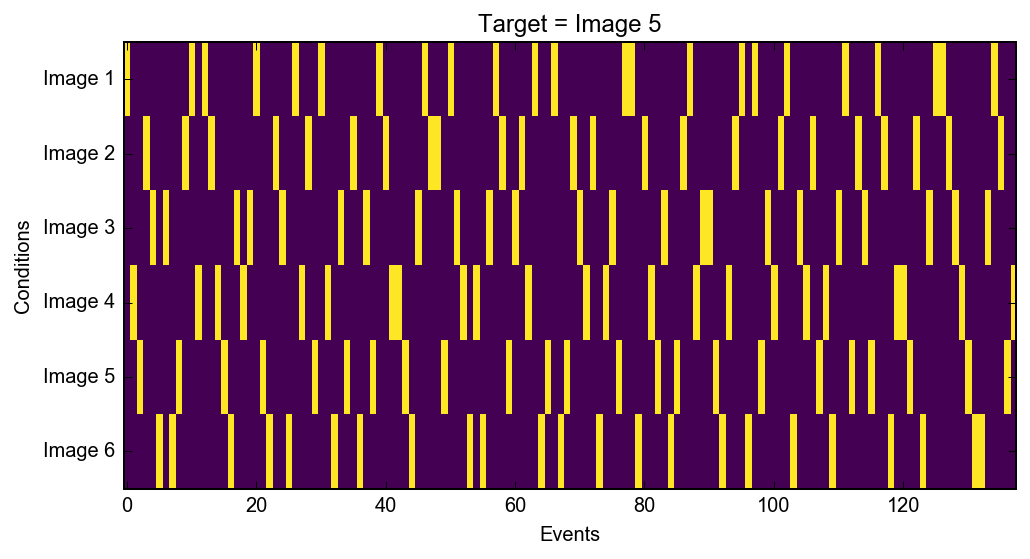

In [52]:
plt.figure(figsize=(8,4))
plt.imshow(design)
plt.xlabel('Events')
plt.ylabel('Conditions')
plt.yticks(range(6), ['Image {}'.format(i) for i in range(1,6+1)])
_ = plt.title('Target = Image {}'.format(target))

In [27]:
print(epochs.keys())
print(epochs[1].shape)

dict_keys([1, 2, 3, 4, 5, 6])
(3, 32, 1432)


In [28]:
# how many trials per condition (per target)
design.sum(1)

array([24, 24, 24, 24, 24, 24])

In [53]:
# Plot mean response to selected stimulus in each electrode
def plot_target_responses(all_epochs, all_images, true_target, ylim=(-5,5)):
    n_images = len(all_images)
    fig, axs = plt.subplots(3, 2, figsize=(10,6), sharey=True,
                            sharex=True)

    # Iterate through each target type
    for ax, (target, epochs) in zip(axs.flatten(), all_epochs.items()):
        # Plot mean of each channel
        average = epochs.mean(0)
        ax.plot(times, average.T, alpha=.5)

        # Global Field Potential
        #grand = average.mean(0)
        grand = (average ** 2).mean(0)
        ax.plot(times, grand, color='k', lw=4)
        ax.axvline(0, color='r', ls='--')
        ax.set(title='Flashed: {}'.format(target))
        ax.grid(axis='x')
        if target == true_target:
            plt.setp(ax.title, color='r')
    if ylim is not None:
        _ = plt.ylim(ylim)
    plt.suptitle('Subject {}, session {}, run {}, target={}'.format(subject, session, run+1, true_target))

# Whole sessions per subject

A problem with several of the subjects was outlying responses at the end of the timecoures. You can see it in this plot. I'm not sure whether we should try to have students find this out themselves or just give it to them (it could be a good exercise in outlier detection).

In [94]:
%matplotlib inline

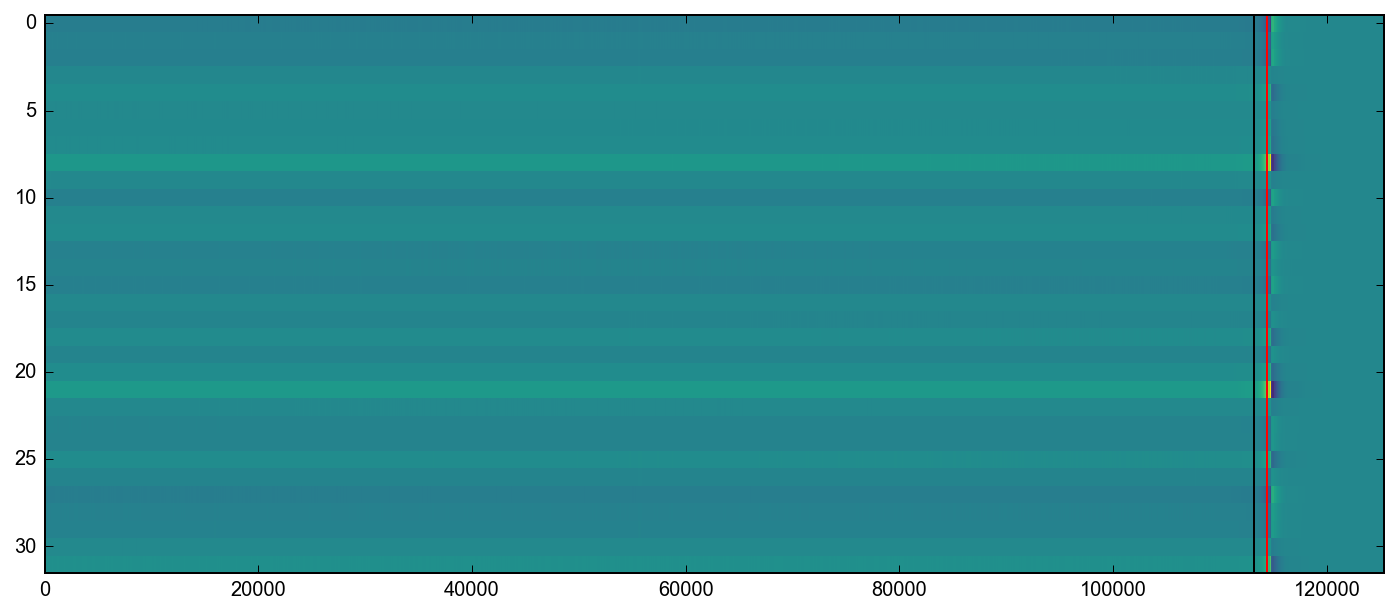

In [98]:
plt.figure(figsize=(12,5))
plt.imshow(data)
# Last trial start (black) and end (red)
plt.vlines(event_times[-1] * sfreq + offset_idx, -0.5, 31.5, color='k')
plt.vlines(event_times[-1] * sfreq + offset_idx + 0.6*sfreq, -0.5, 31.5, color='r')

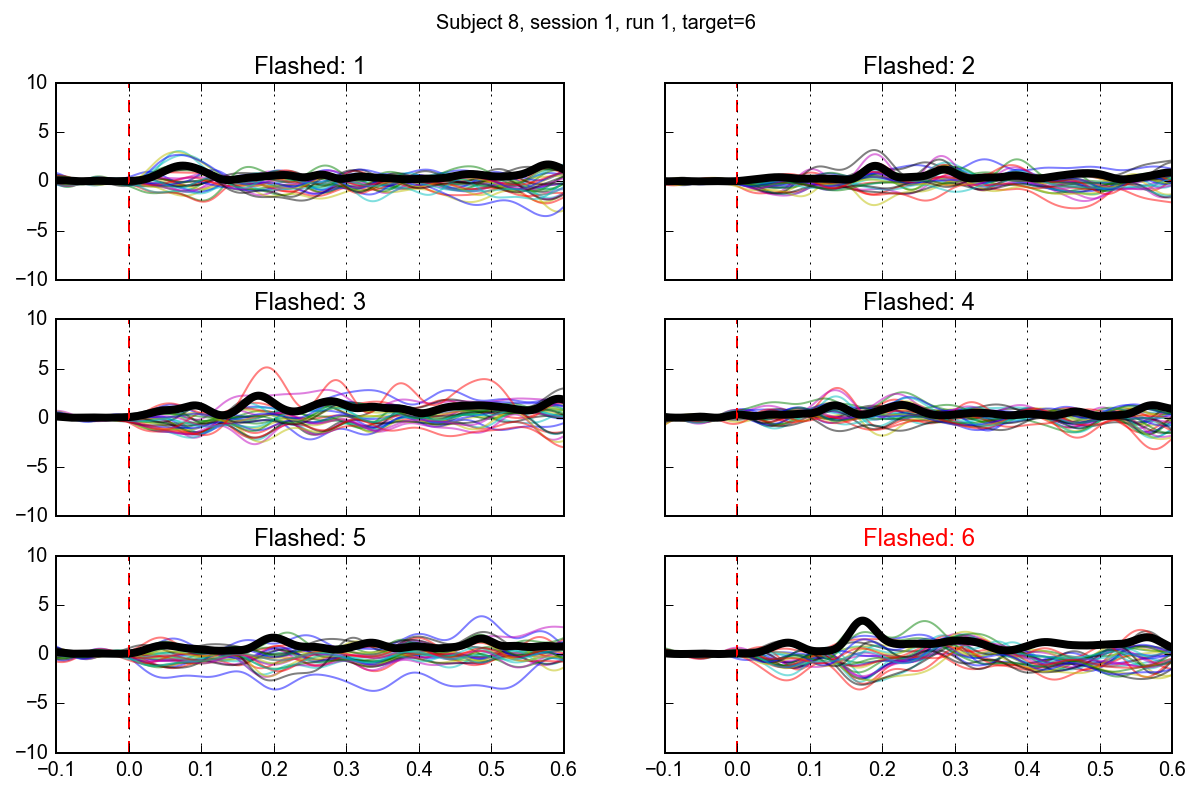

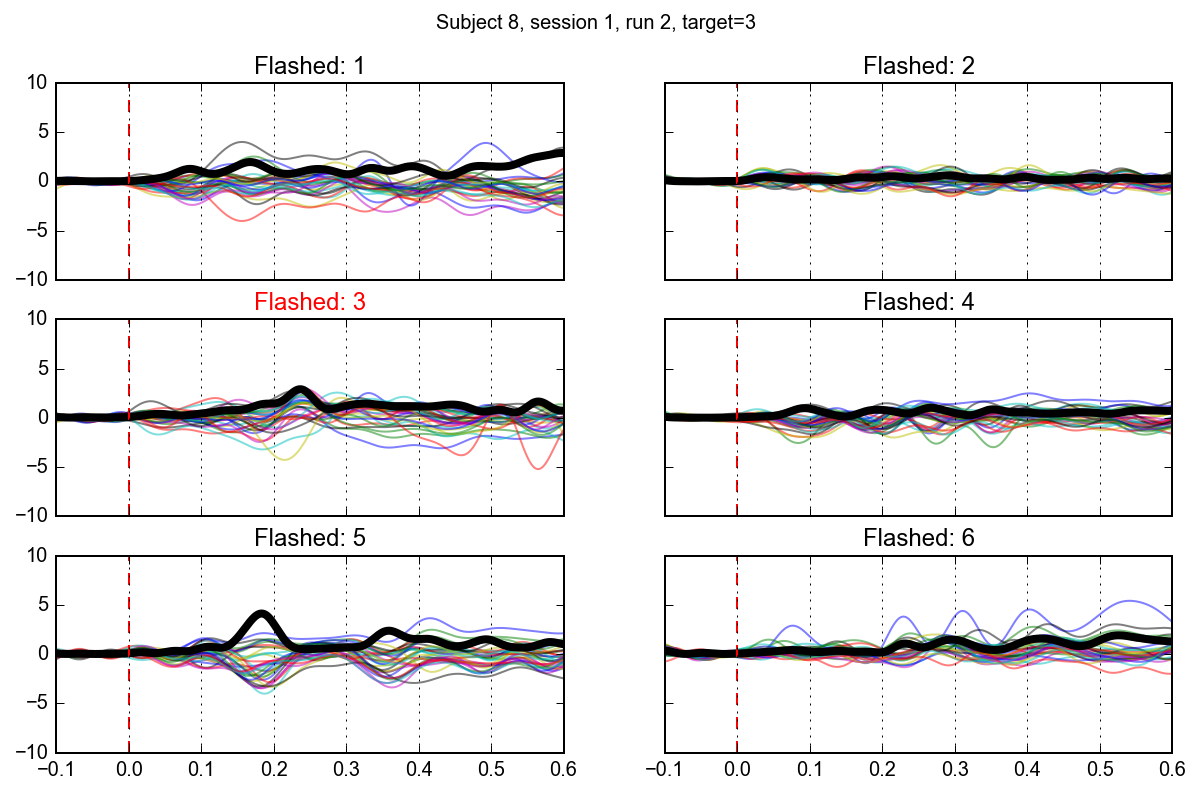

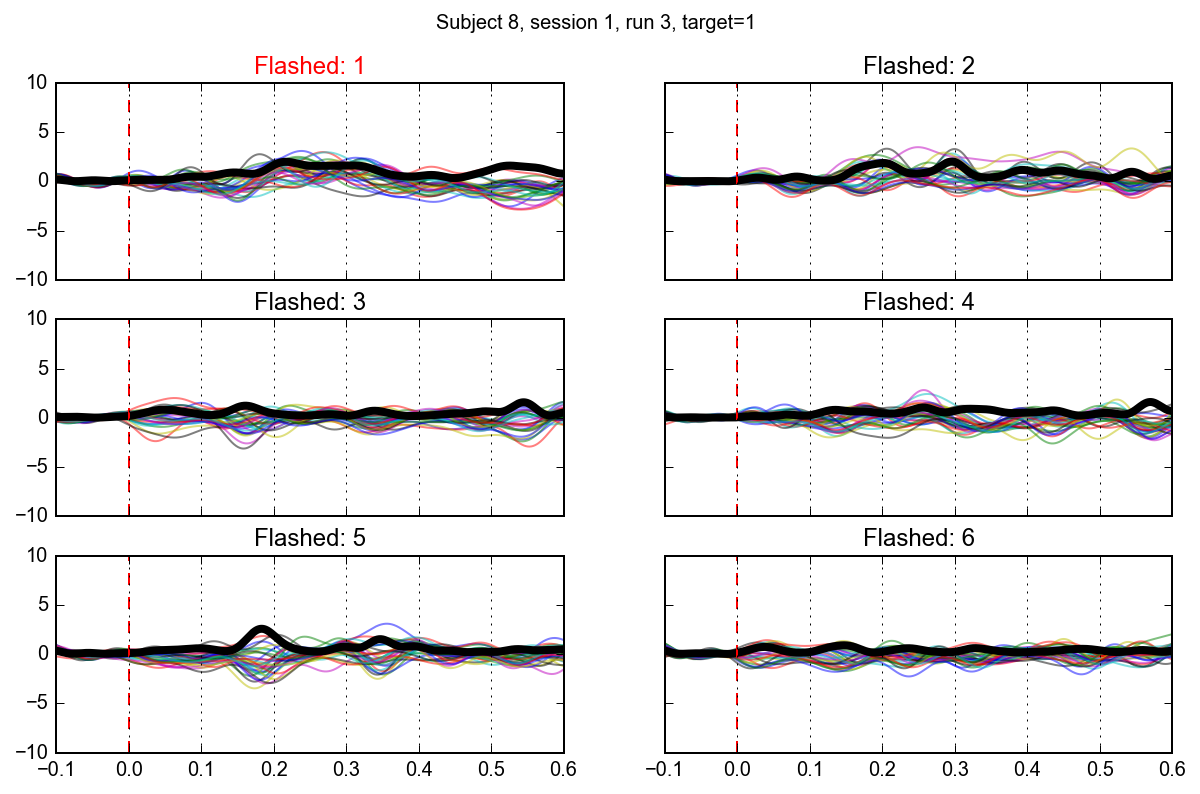

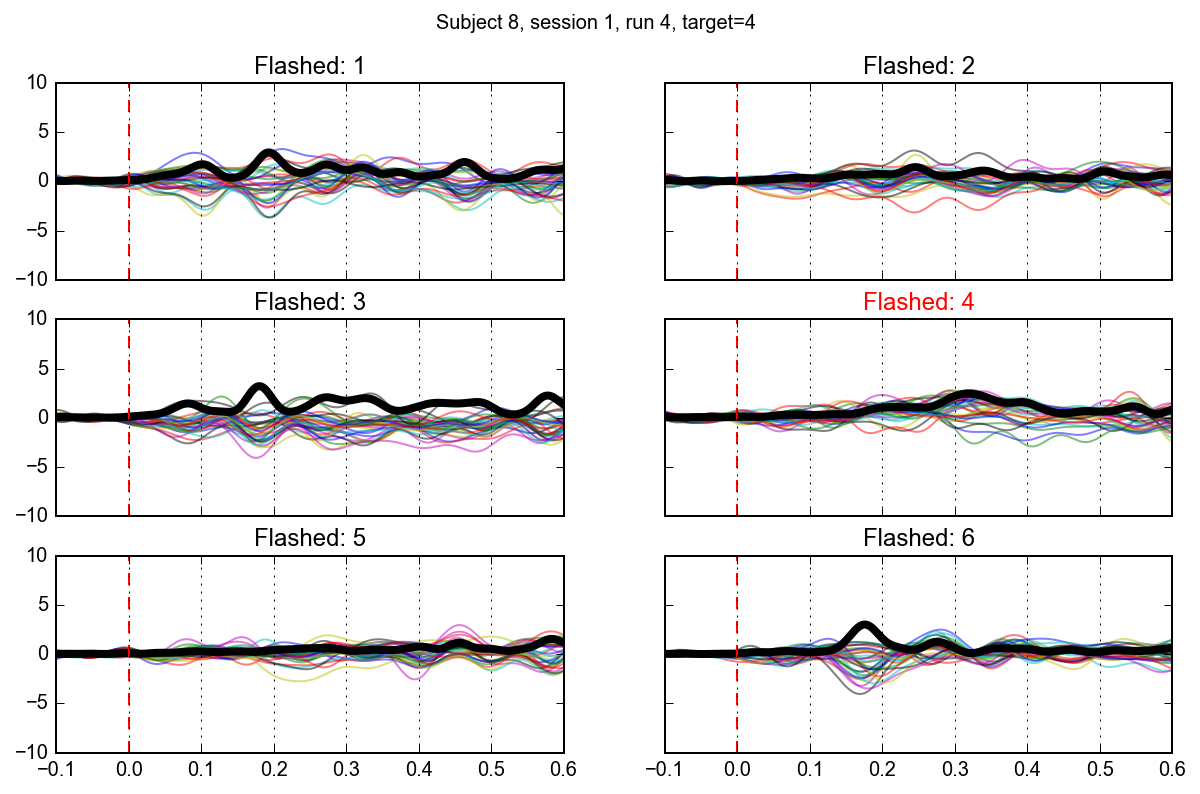

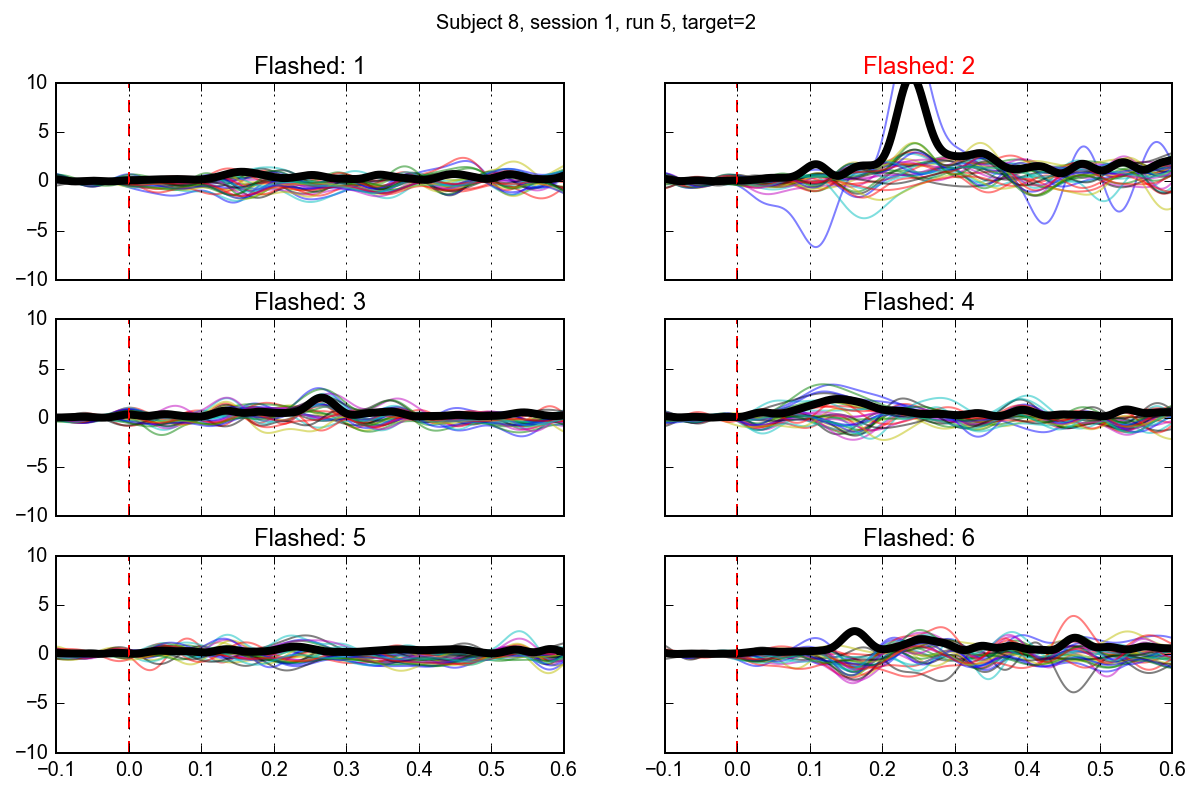

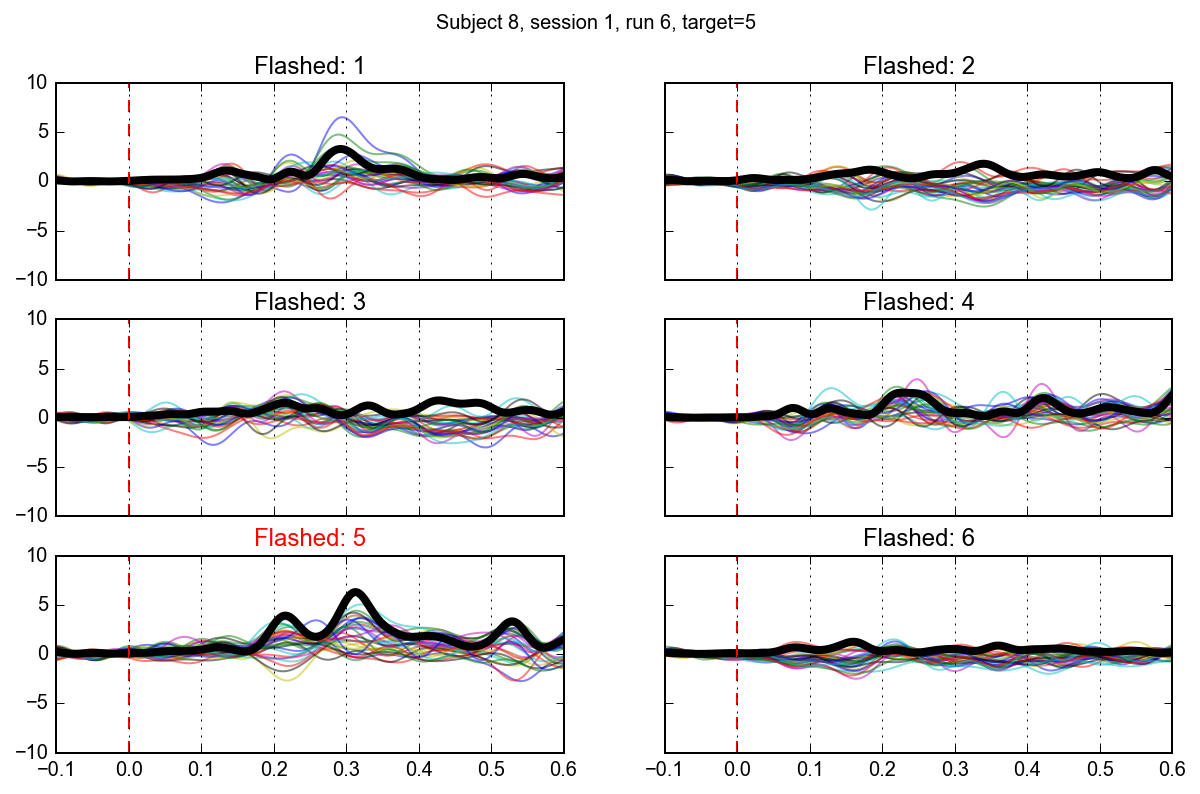

In [59]:
subject = 8 # 1-2 or 8 (9 total, not all downloaded...)
session = 1 # 1-4
for run in range(6): # 1-6
    data, design, event_times, target_counts, target = load_p300_data(subject, session, run)    
    epochs = {}
    for icond, cond in enumerate(design):
        epochs[icond+1], times = extract_epochs(data, event_times[cond][:-1])

    plot_target_responses(epochs, range(6), target, ylim=(-10,10))

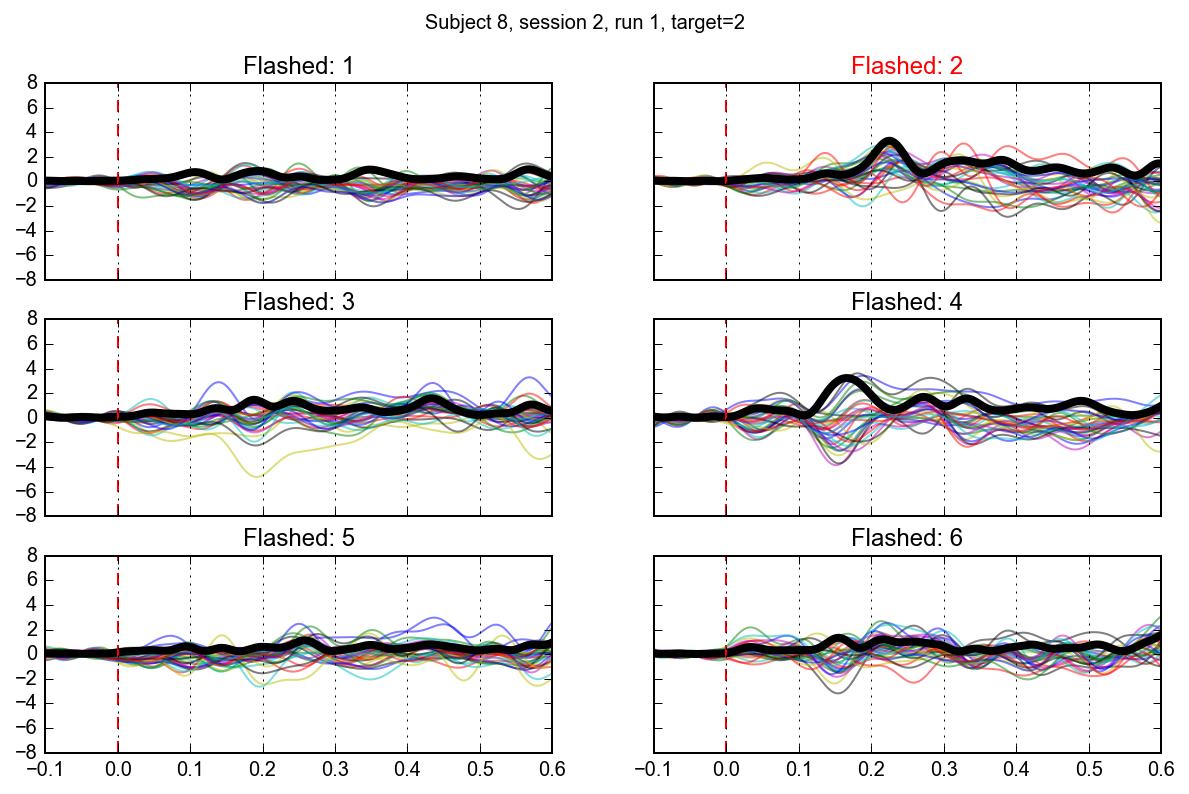

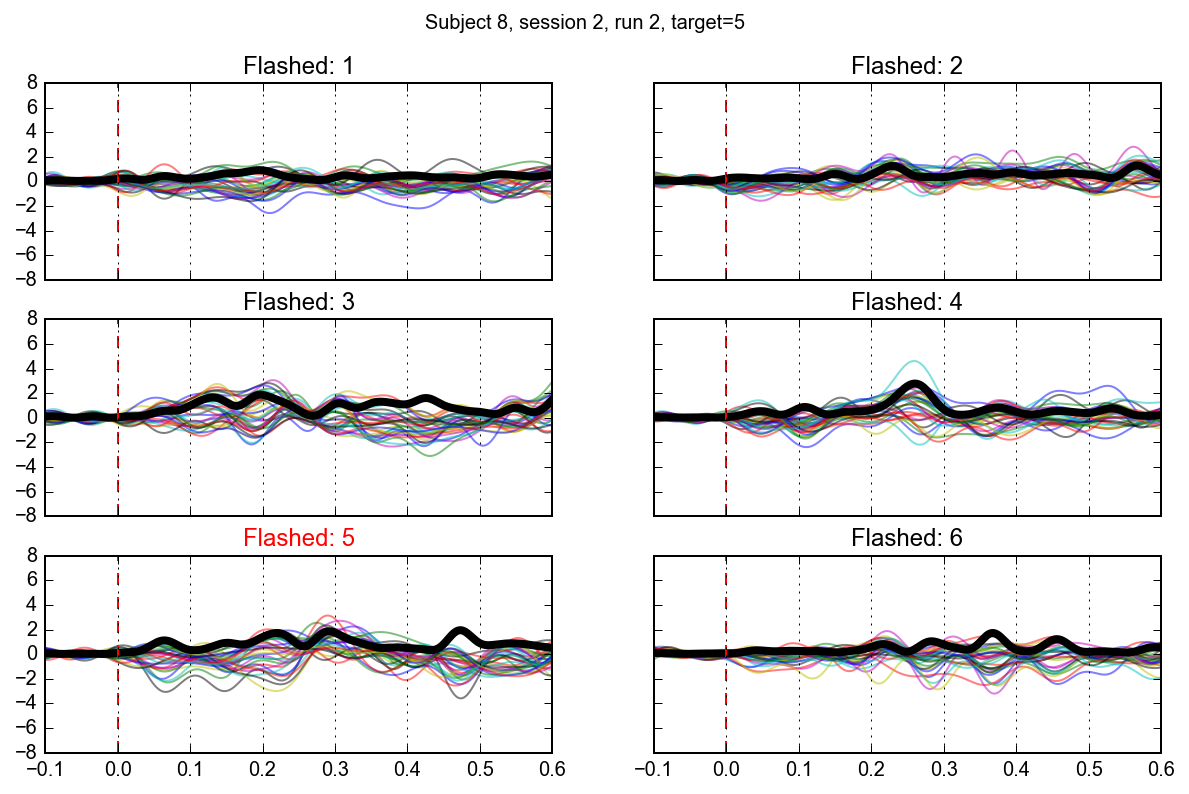

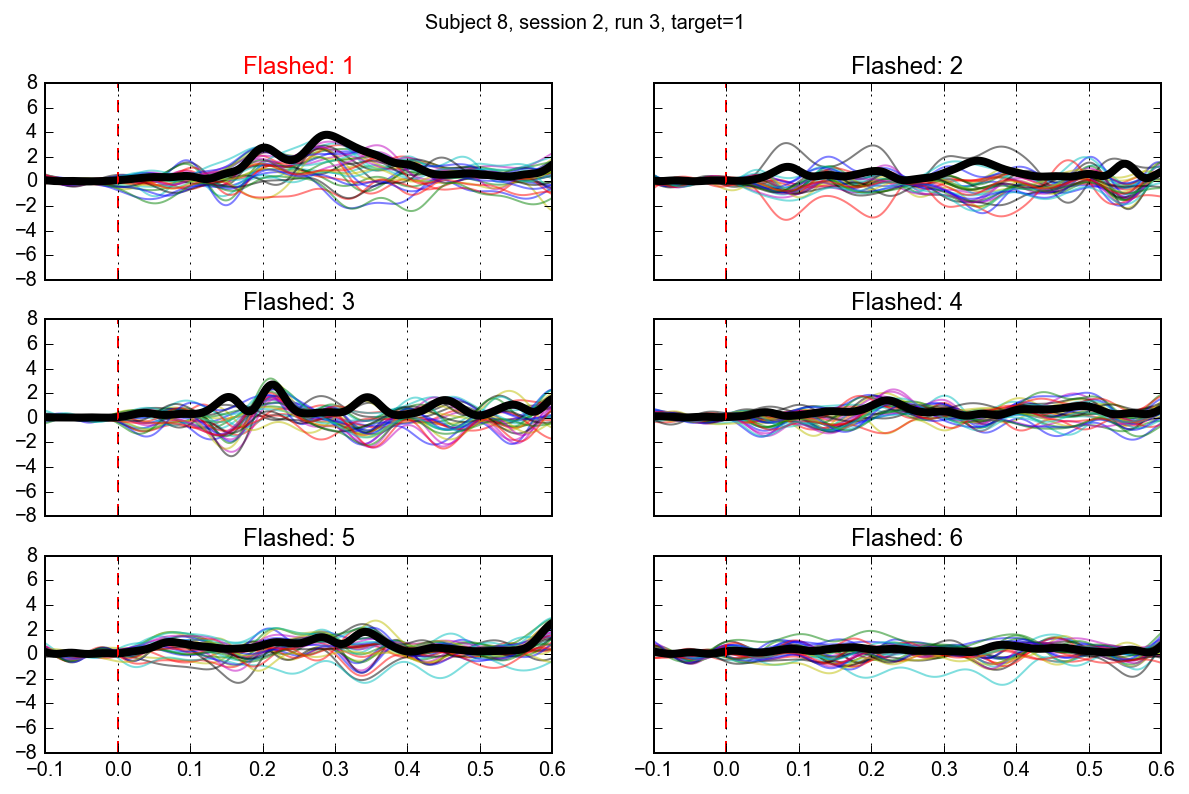

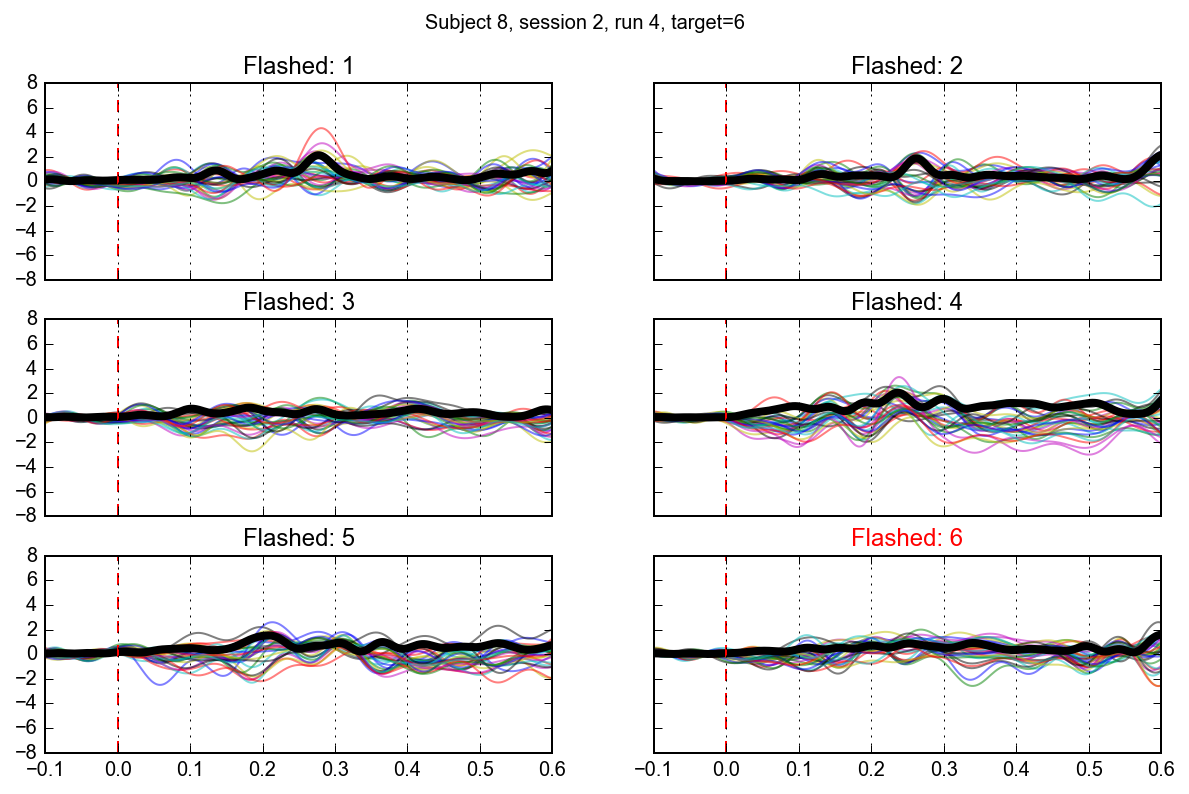

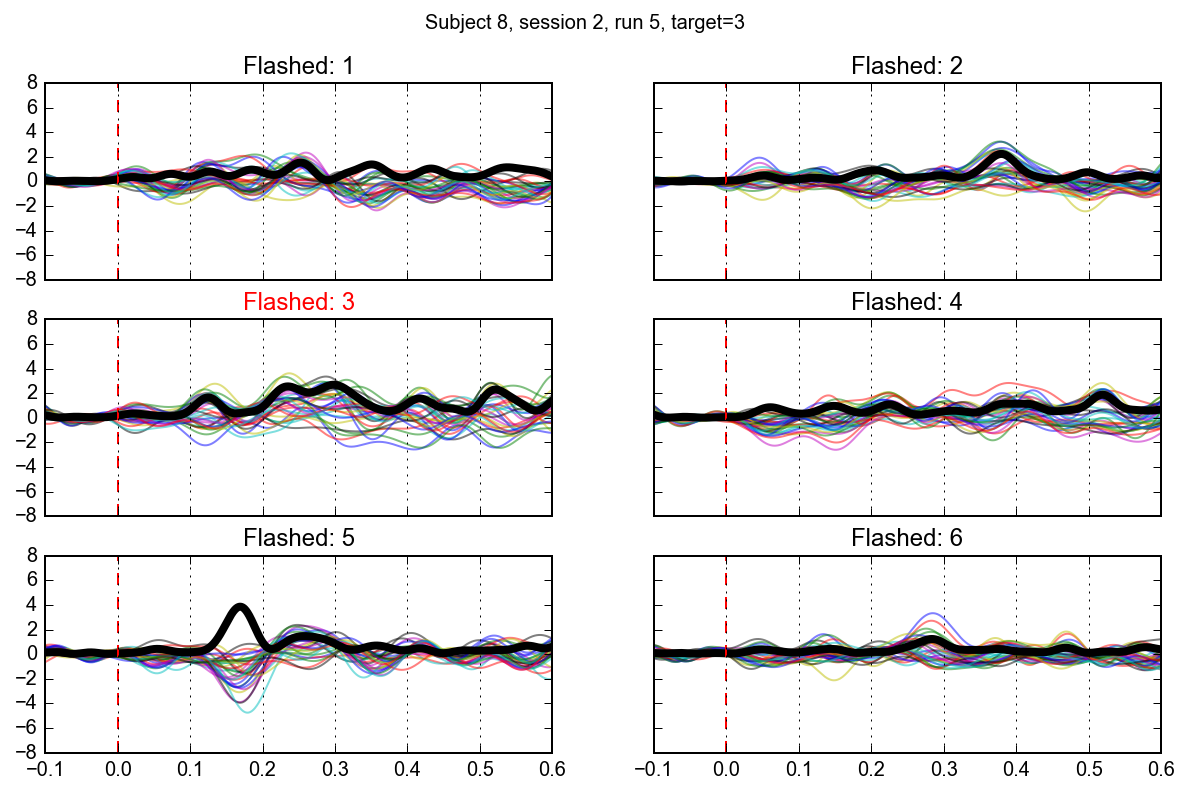

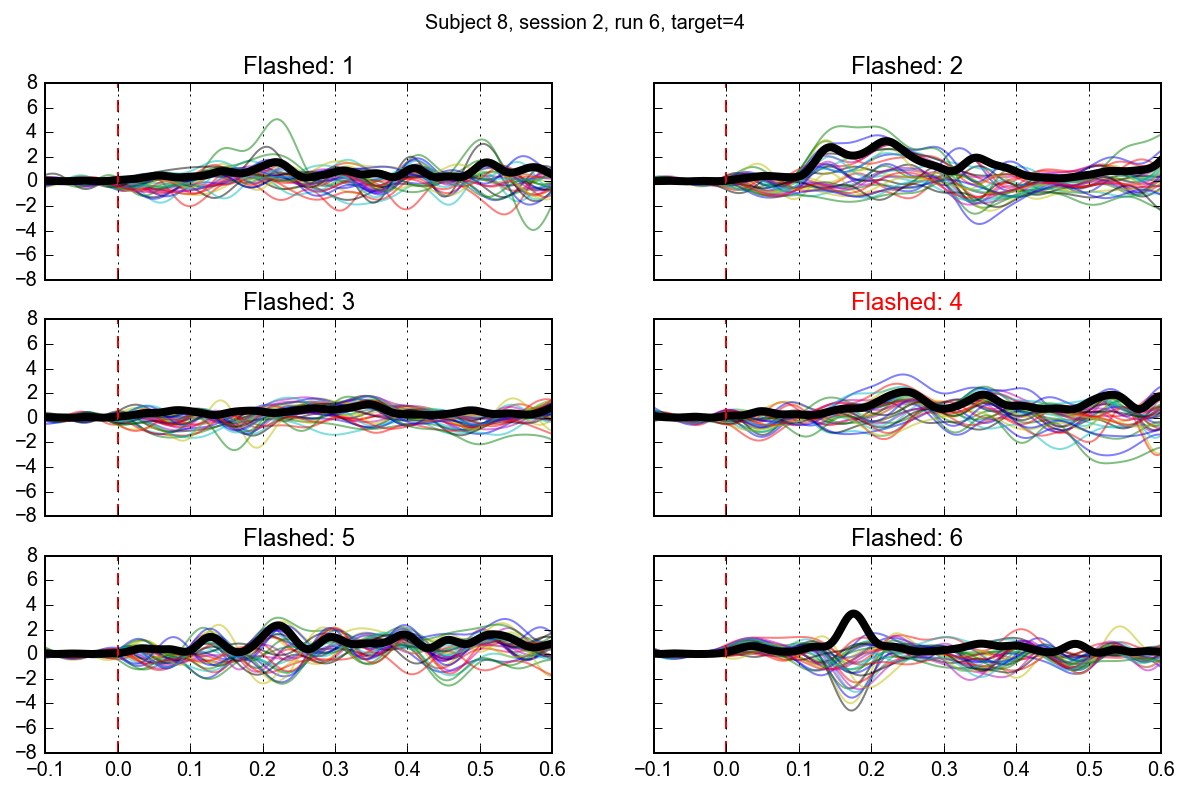

In [68]:
subject = 8 # 1-2 or 8 (9 total, not all downloaded...)
session = 2 # 1-4
for run in range(6): # 1-6
    data, design, event_times, target_counts, target = load_p300_data(subject, session, run)    
    epochs = {}
    for icond, cond in enumerate(design):
        epochs[icond+1], times = extract_epochs(data, event_times[cond][:-1])

    plot_target_responses(epochs, range(6), target, ylim=(-8,8))

# Target vs not-target responses

In [75]:
subject = 8 # 1-2 or 8 (9 total, not all downloaded...)
session = 1 # 1-4
image_as_target = {}
image_not_target = {}
for run in range(6): # 1-6
    data, design, event_times, target_counts, target = load_p300_data(subject, session, run)    
    for icond, cond in enumerate(design, 1):
        epochs_tmp, times = extract_epochs(data, event_times[cond][:-1])
        if icond == target:
            image_as_target[icond] = epochs_tmp
        else:
            if icond not in image_not_target:
                image_not_target[icond] = epochs_tmp
            else:
                image_not_target[icond] = np.vstack([image_not_target[icond], epochs_tmp])

In [76]:
image_not_target[1].shape

(112, 32, 1432)

In [100]:
ax.get_ylim()

(0.0, 3.5)

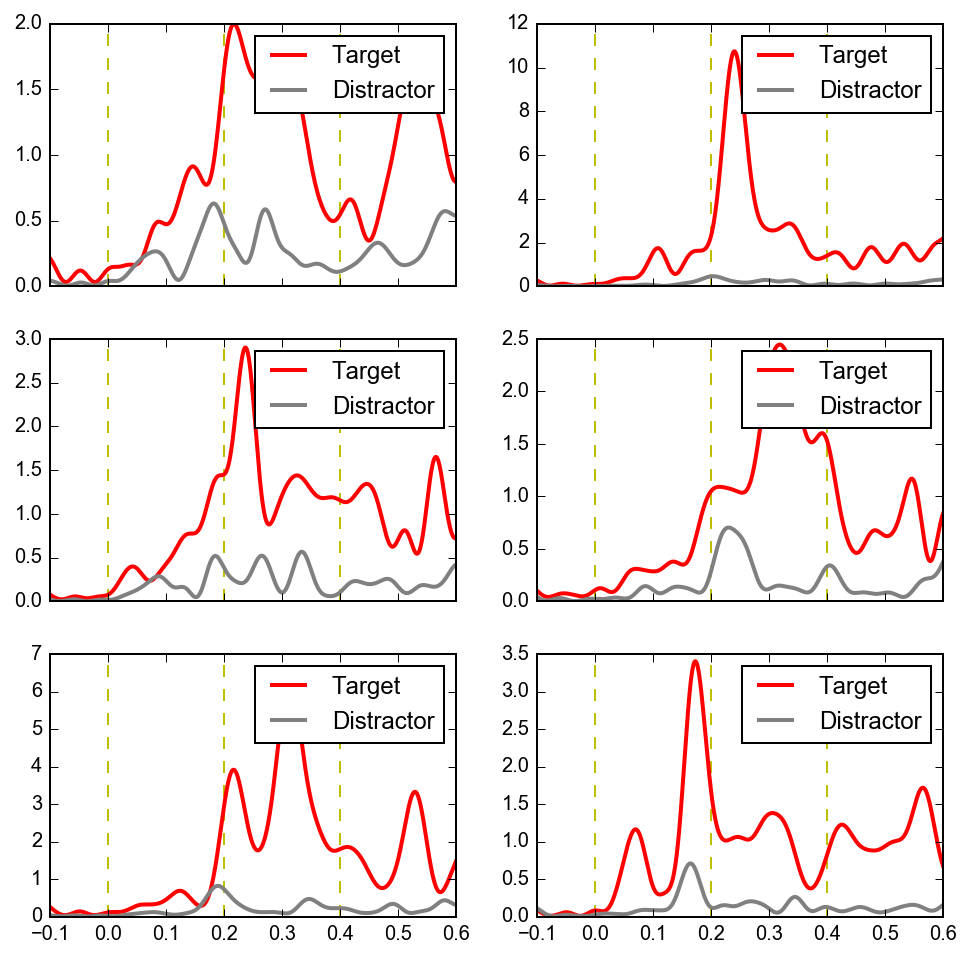

In [103]:
fig, axs = plt.subplots(3, 2, figsize=(8,8), sharey=False, sharex=True)
for ii, ax in enumerate(axs.flatten(), 1):
    ax.plot(times, (image_as_target[ii].mean(0)**2).mean(0), lw=2, color='red', label='Target')
    ax.plot(times, (image_not_target[ii].mean(0)**2).mean(0), lw=2, color='gray', label='Distractor')
    ax.vlines([0, 0.2, 0.4], *ax.get_ylim(), colors='y', linestyle='--')
    ax.legend()

# Original code from Chris

In [41]:
all_targets = np.unique(stimuli) # range(1,7)
all_epochs = {}
for target_plt in all_targets:
    epochs = []
    for time, stimulus  in zip(event_times, stimuli):
        if stimulus != target_plt:
            continue

        # Find event onset index
        diff = time - event_times[0]
        ix_event = int(sfreq * diff) + offset_ixs

        # Calculate window
        tmin, tmax = -.1, .6
        ix_start, ix_stop = [ix_event + int(np.floor(ii * sfreq)) for ii in [tmin, tmax]]
        data_slice = data[:, ix_start:ix_stop]
        data_slice = scale(data_slice.T).T
        epochs.append(data_slice)
    epochs = np.array(epochs)
    times = np.linspace(tmin, tmax, num=epochs.shape[-1])
    
    # Baseline by pre-stimulus times
    baseline_type = 'zscore'  # 'zscore' , 'mean'
    epochs = mne.baseline.rescale(epochs, times, (None, 0), baseline_type)
    all_epochs[target_plt] = epochs

Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)


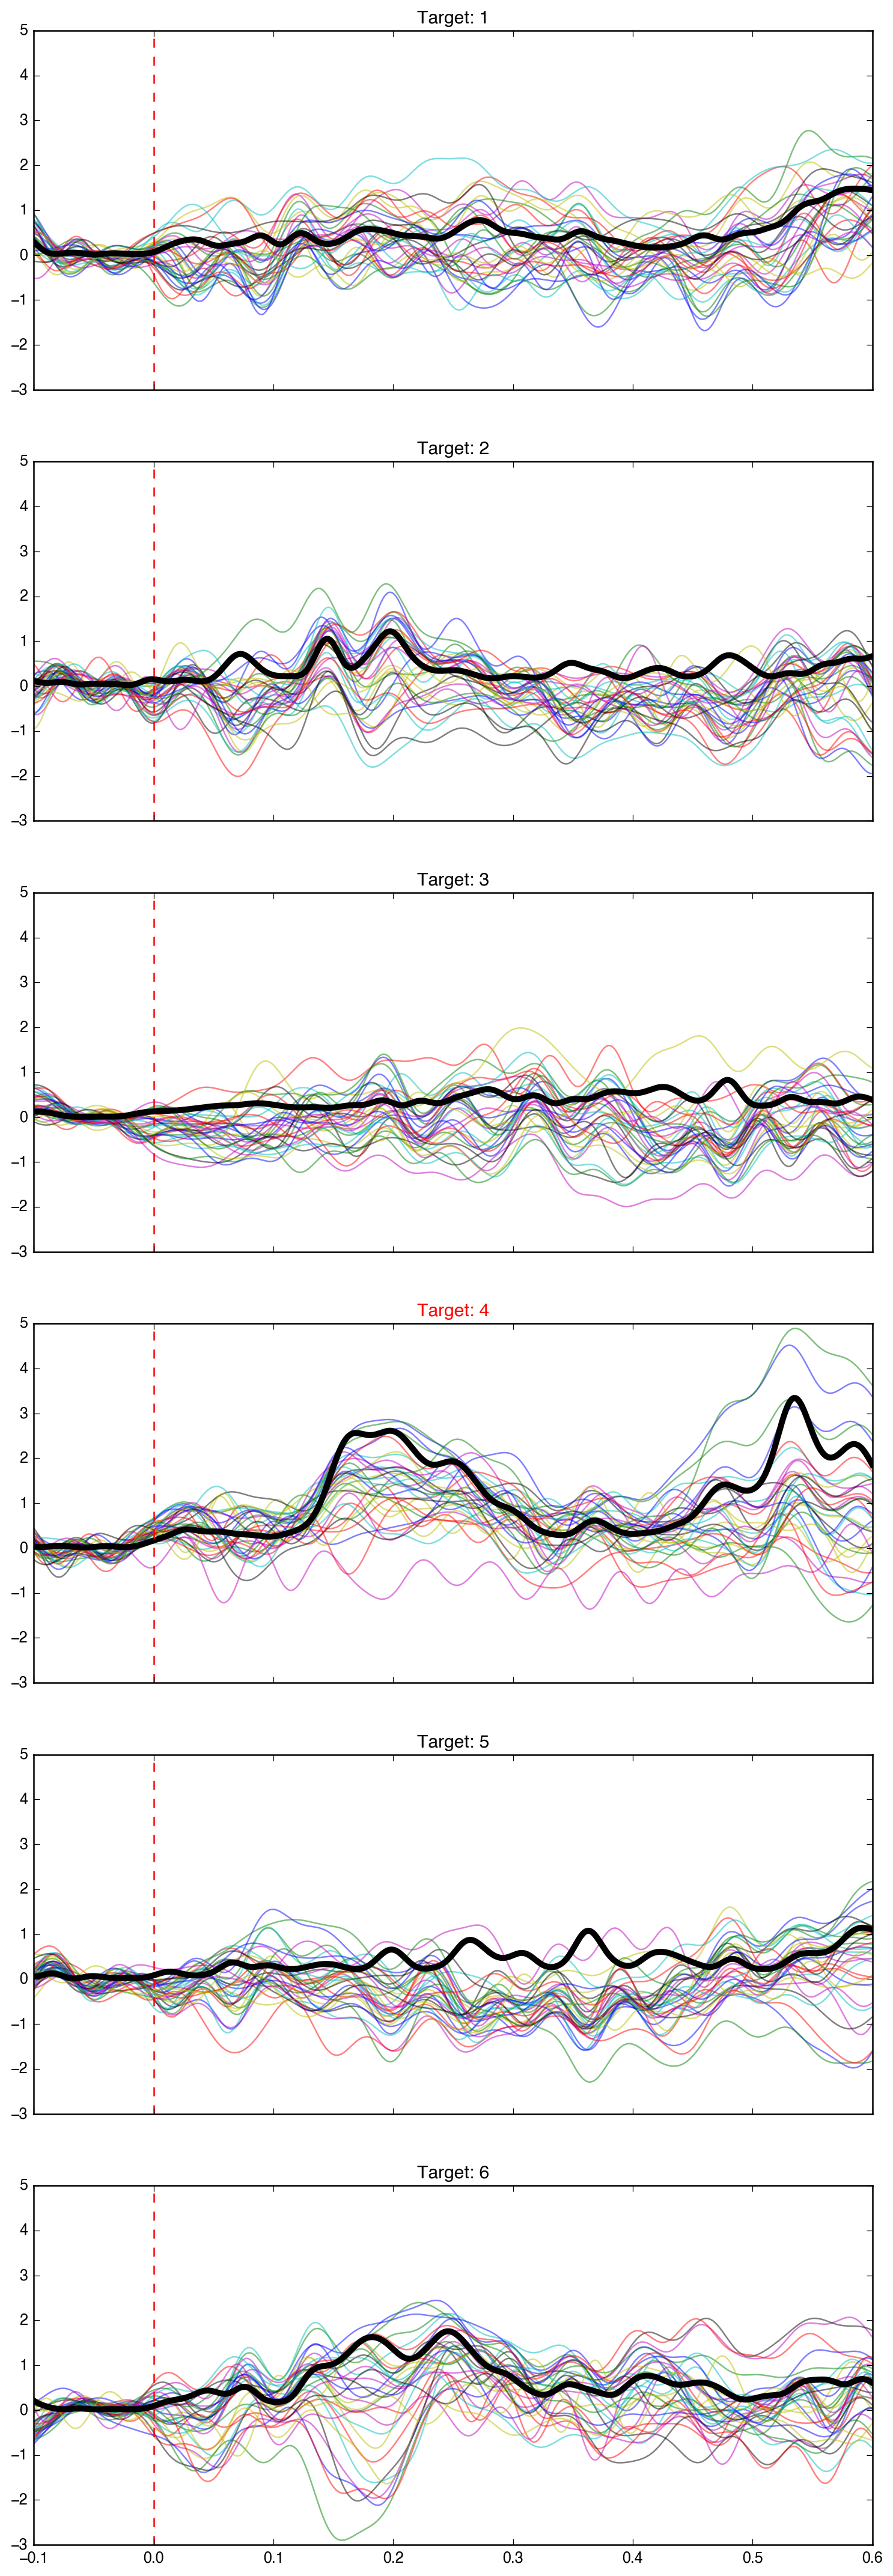

In [15]:
# Plot mean response to selected stimulus in each electrode
n_targets = len(all_targets)
fig, axs = plt.subplots(n_targets, 1, figsize=(10, 5 * n_targets), sharey=True,
                        sharex=True)

# Iterate through each target type
for ax, (target, epochs) in zip(axs, all_epochs.items()):
    # Plot mean of each channel
    average = epochs.mean(0)
    ax.plot(times, average.T, alpha=.5)
    
    # Global Field Potential
    grand = (average ** 2).mean(0)
    ax.plot(times, grand, color='k', lw=4)
    ax.axvline(0, color='r', ls='--')
    ax.set(title='Target: {}'.format(target))
    if target == true_target:
        plt.setp(ax.title, color='r')

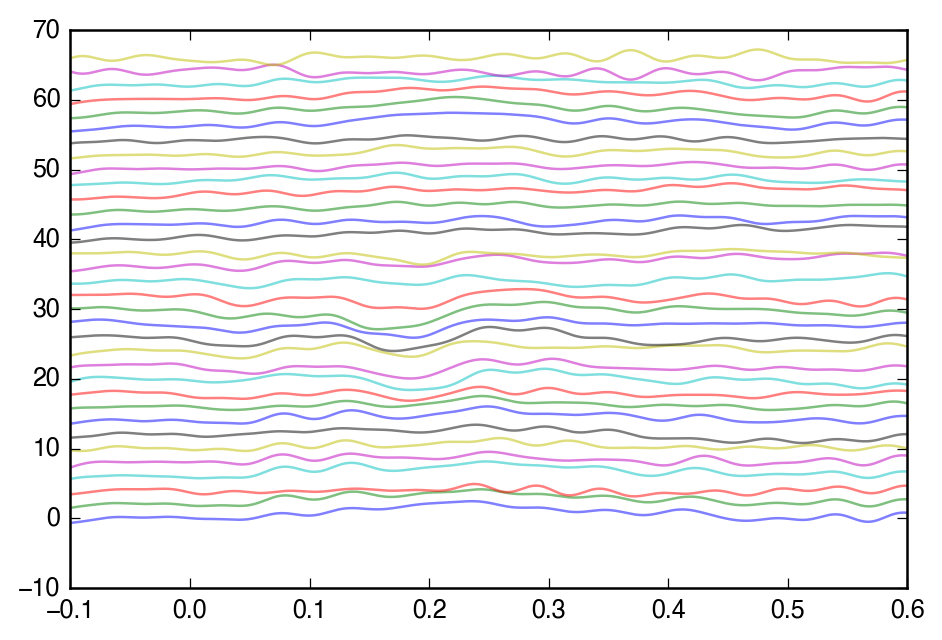

In [16]:
# Show all channels w/ offset
# Maybe good to show before the plots above
for ii, av in enumerate(average):
    _ = plt.plot(times, av + ii * 2, alpha=.5)